In [ ]:
import os, zipfile, random, math, joblib, shutil, gc, json, time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import torch
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from scipy.stats import randint, uniform
from skimage.feature import hog
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, precision_recall_fscore_support, confusion_matrix,
    classification_report, ConfusionMatrixDisplay
)
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

## Data Loading and Exploratory Data Analysis (EDA)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = "/content/drive/My Drive/dataset/Comp6721_Project_Dataset.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

train_dir = "/content/Training"
test_dir = "/content/Test"
print("Train subfolders (classes):", os.listdir(train_dir))
print("Test subfolders (classes):", os.listdir(test_dir))

Train subfolders (classes): ['museum-indoor', 'shopping_mall-indoor', 'library-indoor']
Test subfolders (classes): ['museum-indoor', 'shopping_mall-indoor', 'library-indoor']


In [ ]:
# Create an ImageFolder dataset with only ToTensor transform
# This will load RGB images and convert them to tensors [0, 1]
train_data_original = ImageFolder(train_dir, transform=transforms.ToTensor())
test_data_original  = ImageFolder(test_dir , transform=transforms.ToTensor())
# Get the class names from this dataset instance
class_names_original = train_data_original.classes

print("Classes:", class_names_original)
print(f"Number of training images (original): {len(train_data_original)}")
print(f"Number of test images: {len(test_data_original)}")

Classes: ['library-indoor', 'museum-indoor', 'shopping_mall-indoor']
Number of training images (original): 15000
Number of test images: 300


**Class Distribution**

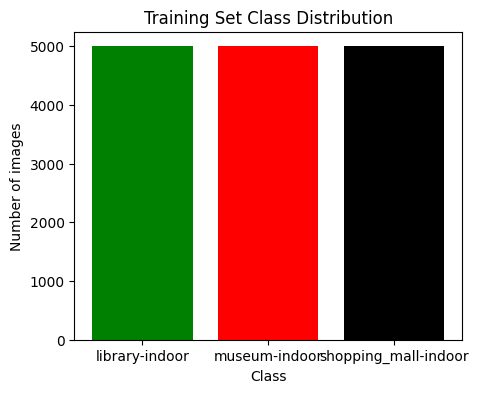

Training images per class: {'library-indoor': 5000, 'museum-indoor': 5000, 'shopping_mall-indoor': 5000}
Test images per class: {'library-indoor': 100, 'museum-indoor': 100, 'shopping_mall-indoor': 100}


In [ ]:
train_labels = [label for _, label in train_data_original]
test_labels = [label for _, label in test_data_original]

train_counts = pd.Series(train_labels).value_counts().sort_index()
test_counts  = pd.Series(test_labels).value_counts().sort_index()

# Plot class distribution
plt.figure(figsize=(5,4))
plt.bar(class_names_original, train_counts, color=['green','red','black'])
plt.title("Training Set Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.show()

print("Training images per class:", {name: count for name, count in zip(class_names_original, train_counts)})
print("Test images per class:", {name: count for name, count in zip(class_names_original, test_counts)})

**Sample Images per Class**

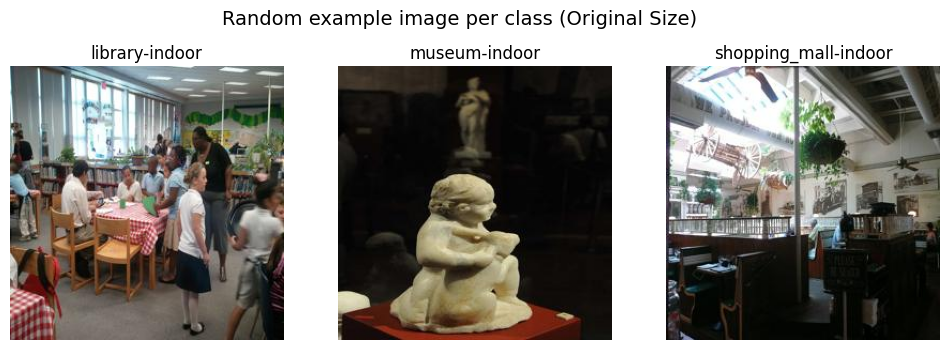

In [ ]:
fig, axes = plt.subplots(1, len(class_names_original), figsize=(12, 4))

for idx, cls in enumerate(class_names_original):
    # Find indices for the current class using the raw dataset's samples
    cls_indices = [i for i, (_, lbl) in enumerate(train_data_original.samples) if lbl == idx]

    # Randomly pick one index from this class
    rnd_idx = random.choice(cls_indices)

    # Get the image and label from the raw dataset using the random index
    # train_data_original[rnd_idx] returns (Tensor_image, label) in [0, 1] range
    img_tensor = train_data_original[rnd_idx][0] # Get the tensor

    # Convert the PyTorch tensor from (C, H, W) to NumPy array (H, W, C)
    # Assuming all images are RGB (3 channels)
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy() # C, H, W -> H, W, C

    # Display the image using imshow
    axes[idx].imshow(img_np)
    axes[idx].set_title(cls)
    axes[idx].axis("off")

plt.suptitle("Random example image per class (Original Size)", fontsize=14)
plt.show()

**Pixel Intensity Distribution**

In [ ]:
mean_intensity_original = []
mean_by_class_original  = {c: [] for c in class_names_original}

# Iterate through the dataset with ToTensor transform
for img_tensor_original, lbl_original in train_data_original:
    # img_tensor_original is already a tensor [C, H, W] in [0, 1]
    # Calculate the mean intensity across all channels and pixels
    mu_original = img_tensor_original.mean().item()

    mean_intensity_original.append(mu_original)
    mean_by_class_original[class_names_original[lbl_original]].append(mu_original)

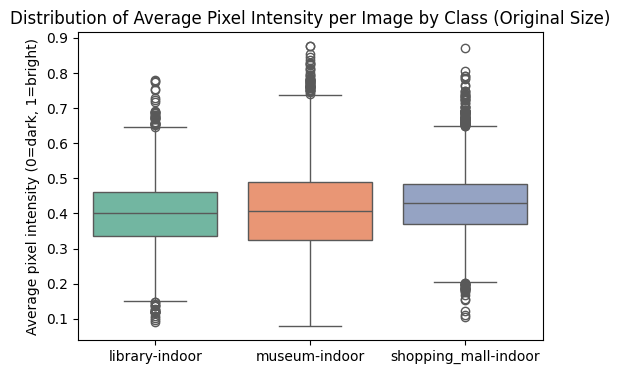


Overall mean pixel value (original) : 0.41407772960960865
Overall std  pixel value (original) : 0.10594611328884272


In [ ]:
# Plot the distribution of average pixel intensity per class for original images
plt.figure(figsize=(6,4))
sns.boxplot(data=[mean_by_class_original[c] for c in class_names_original], palette="Set2")
plt.xticks(ticks=range(len(class_names_original)), labels=class_names_original)
plt.ylabel("Average pixel intensity (0=dark, 1=bright)")
plt.title("Distribution of Average Pixel Intensity per Image by Class (Original Size)")
plt.show()

print("\nOverall mean pixel value (original) :", np.mean(mean_intensity_original))
print("Overall std  pixel value (original) :", np.std (mean_intensity_original))

## Feature Extraction Pipeline – Overview  
We combine four complementary handcrafted descriptors to capture **shape**, **colour**, **texture**, and **salient local patches**:

| Component | Why we use it | Key parameters |
|-----------|---------------|----------------|
| **HOG** (Histogram of Oriented Gradients) | Robust to illumination; captures object contours & edges | 16 × 16 cells, 2 × 2 blocks, 9 bins |
| **Colour histogram** | Encodes overall colour palette (useful for distinctive scenes) | 64 total RGB bins |
| **Uniform LBP** | Captures micro-texture patterns (e.g. foliage vs. bricks) | Radii 1 & 2, 8 × R sampling |
| **BoVW w/ ORB** | Keypoint-based patch vocabulary; efficient alternative to SIFT | 200 ORB keypoints, 600-word k-means codebook |

All descriptors are concatenated into a single ~2,500-dimensional feature vector before entering the classifiers.


In [ ]:
IMG_SIZE = (128,128)        #(128, 128) -> 16.128 / (256x256) -> 65.536
HOG_CELL = (16, 16)         # or (8,8) more information but slower
HOG_BLOCK = (2, 2)
HOG_BINS = 9
HIST_BINS = 64              # 16, 32 -> 1860, or 64

In [ ]:
class GrayRGBTransform:
    """Resize once, return grayscale PIL and RGB PIL."""
    def __init__(self, size=IMG_SIZE):
        self.resize = transforms.Resize(size)

    def __call__(self, img):
        rgb = self.resize(img)              # PIL RGB
        gray = rgb.convert("L")             # PIL grayscale
        return gray, rgb

In [ ]:
train_data = datasets.ImageFolder(train_dir, transform=GrayRGBTransform())
test_data  = datasets.ImageFolder(test_dir , transform=GrayRGBTransform())

class_names = train_data.classes
print("Classes:", class_names)
print(f"Number of training images: {len(train_data)}")
print(f"Number of test images: {len(test_data)}")

Classes: ['library-indoor', 'museum-indoor', 'shopping_mall-indoor']
Number of training images: 15000
Number of test images: 300


### HOG + Colour Extraction  
This helper function:

1. Resizes the input image to **128 × 128** (smaller = faster, still preserves global structure).  
2. Converts to *grayscale* and computes a HOG descriptor  
   * 16 × 16 pixel cells  
   * 2 × 2 block normalisation  
   * 9 orientation bins.  
3. Computes a **64-bin** RGB colour histogram
4. Returns the concatenated feature vector.  

In [ ]:
hog_cfg = dict(orientations=HOG_BINS,
               pixels_per_cell=HOG_CELL,
               cells_per_block=HOG_BLOCK,
               visualize=False,
               channel_axis=None)

def hog_plus_colour(gray_pil, rgb_pil):
    """Return 1-D HOG + colour-hist feature vector."""
    # HOG (on grayscale)
    gray_np = np.array(gray_pil)            # uint8 128×128
    hog_vec = hog(gray_np, **hog_cfg).astype(np.float32)

    # Colour histogram per channel
    rgb_np = np.array(rgb_pil)              # uint8 H×W×3
    hist_feats = []
    for ch in range(3):
        hist, _ = np.histogram(
            rgb_np[..., ch],
            bins=HIST_BINS,
            range=(0, 255)
        )
        hist   = hist.astype(np.float32)
        hist  /= (hist.sum() + 1e-7)        # L1-normalize
        hist_feats.append(hist)
    colour_vec = np.concatenate(hist_feats)

    return np.hstack([hog_vec, colour_vec])

In [ ]:
# Build feature matrices
def build_matrix(ds):
    """ds: ImageFolder that returns (gray_pil, rgb_pil), label."""
    X, y = [], []
    for (gray_pil, rgb_pil), label in ds:
        X.append(hog_plus_colour(gray_pil, rgb_pil))
        y.append(label)
    return np.vstack(X).astype(np.float32), np.array(y)

print("Extracting TRAIN features ...")
X_train_full, y_train_full = build_matrix(train_data)
print("Full train feature shape:", X_train_full.shape)
print("Extracting TEST features ...")
X_test, y_test = build_matrix(test_data)
print("Test feature shape:",       X_test.shape)

Extracting TRAIN features ...
Full train feature shape: (15000, 1956)
Extracting TEST features ...
Test feature shape: (300, 1956)


### BoVW + LBP – Loading Pre-computed Descriptors

The Bag-of-Visual-Words (600-word ORB codebook) plus multi-scale LBP (radii 1 & 2) features were extracted **offline in a separate notebook** and saved to  
`scene_bovw_lbp_features.npz`.

The following cells:

1. **Load** the compressed arrays for Train / Val / Test.  
2. Verify that label ordering matches the HOG/colour feature matrices  
   (sanity checks with `assert`).  
3. **Horizontally stack** HOG+Colour (≈1.8 k dims) with BoVW+LBP (628 dims) to form a single **hybrid vector** (~2.4 k dims).  
4. Creates `X_train_hybrid`, `X_val_hybrid`, `X_test_hybrid` and aligned label vectors for subsequent model training.

In [ ]:
# feature loading
SAVE_PATH = "/content/drive/MyDrive/COMP6721/scene_bovw_lbp_features.npz"
data_bovw = np.load(SAVE_PATH, allow_pickle=True)
X_train_bovw = data_bovw['X_train']   # shape (n_train_sub, D_bovw)
y_train_bovw = data_bovw['y_train']
X_val_bovw   = data_bovw['X_val']     # shape (n_val, D_bovw)
y_val_bovw   = data_bovw['y_val']
X_test_bovw  = data_bovw['X_test']    # shape (n_test, D_bovw)
y_test_bovw  = data_bovw['y_test']
classes      = data_bovw['classes']

print("BoVW+LBP shapes:",
      X_train_bovw.shape, X_val_bovw.shape, X_test_bovw.shape)

BoVW+LBP shapes: (13500, 628) (1500, 628) (300, 628)


In [ ]:
assert np.array_equal(np.sort(y_test), np.sort(y_test_bovw)), "Test labels mismatch!"
# Also: the sorted unique train labels should match
assert np.array_equal(np.sort(np.unique(y_train_full)),
                      np.sort(np.unique(y_train_bovw))), "Train-label sets differ!"

In [ ]:
X_train_hog, X_val_hog, y_train_hog, y_val_hog = train_test_split(
    X_train_full, y_train_full,
    test_size=0.10,
    stratify=y_train_full,
    random_state=42
)

print("HOG train/val split:",
      X_train_hog.shape, X_val_hog.shape, X_test.shape,
      "labels:", y_train_hog.shape, y_val_hog.shape, y_test.shape)


HOG train/val split: (13500, 1956) (1500, 1956) (300, 1956) labels: (13500,) (1500,) (300,)


In [ ]:
assert np.array_equal(y_train_hog, y_train_bovw), \
       "Mismatch: HOG train labels and BoVW train labels differ—check ordering."
assert np.array_equal(y_val_hog, y_val_bovw),   \
       "Mismatch: HOG val labels and BoVW val labels differ—check ordering."
assert np.array_equal(y_test, y_test_bovw),     \
       "Mismatch: HOG test labels and BoVW test labels differ—check ordering."

print("Train/Val/Test labels align across HOG and BoVW splits.")

Train/Val/Test labels align across HOG and BoVW splits.


In [ ]:
# Use np.hstack (they have the same number of rows now)
X_train_hybrid = np.hstack([X_train_hog, X_train_bovw])
X_val_hybrid   = np.hstack([X_val_hog,   X_val_bovw])
X_test_hybrid  = np.hstack([X_test,  X_test_bovw])

print("Hybrid feature dims:",
      X_train_hybrid.shape,
      X_val_hybrid.shape,
      X_test_hybrid.shape)
# e.g., (n_train_sub, D_hog + D_bovw), etc.

# The labels are the same:
y_train_hybrid = y_train_hog   # or y_train_bovw, they are equal
y_val_hybrid   = y_val_hog
y_test_hybrid  = y_test       # or y_test_bovw

Hybrid feature dims: (13500, 2584) (1500, 2584) (300, 2584)


In [ ]:
np.savez_compressed(
    "/content/drive/MyDrive/COMP6721/hog_bovw_hybrid.npz",
    X_train=X_train_hybrid,  y_train=y_train_hybrid,
    X_val=X_val_hybrid,      y_val=y_val_hybrid,
    X_test=X_test_hybrid,    y_test=y_test_hybrid,
    classes=classes
)
print("Saved hybrid features to Drive.")

Saved hybrid features to Drive.


In [ ]:
# feature loading
SAVE_PATH = "/content/drive/MyDrive/COMP6721/hog_bovw_hybrid.npz"
data_hybrid = np.load(SAVE_PATH, allow_pickle=True)
X_train_hybrid = data_hybrid['X_train']   # shape (n_train_sub, D_bovw)
y_train_hybrid = data_hybrid['y_train']
X_val_hybrid   = data_hybrid['X_val']     # shape (n_val, D_bovw)
y_val_hybrid   = data_hybrid['y_val']
X_test_hybrid  = data_hybrid['X_test']    # shape (n_test, D_bovw)
y_test_hybrid  = data_hybrid['y_test']
classes      = data_hybrid['classes']

print("BoVW+LBP shapes:",
      X_train_bovw.shape, X_val_bovw.shape, X_test_bovw.shape)

**Evaluation Function**

In [ ]:
def evaluate_model(name, model,
                   X_train, y_train,
                   X_val,   y_val,
                   X_test,  y_test,
                   classes):
    """
    Prints classification report.
    Plots confusion matrices for TRAIN/VAL/TEST.
    Return a dict of metrics.
    """
    metrics = {}

    for split, X, y in [
        ("TRAIN",      X_train, y_train),
        ("VALIDATION", X_val,   y_val),
        ("TEST",       X_test,  y_test)
    ]:
        y_pred = model.predict(X)

        # store scalar metrics
        metrics[f"{split}_acc"]   = accuracy_score(y, y_pred)
        metrics[f"{split}_f1"]    = f1_score(y, y_pred, average="macro")
        metrics[f"{split}_prec"]  = precision_score(y, y_pred, average="macro")
        metrics[f"{split}_rec"]   = recall_score(y, y_pred, average="macro")

        # classification report
        print(f"\n{name} — {split} SET")
        print(classification_report(y, y_pred, target_names=classes, digits=3))

        # confusion matrix plot
        cm = confusion_matrix(y, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                    xticklabels=classes, yticklabels=classes)
        plt.title(f"{name} – {split} Confusion")
        plt.xlabel("Predicted"); plt.ylabel("Actual")
        plt.show()

    return metrics

## Random Forest Classifier

### Random Forest – Randomised Hyperparameter Search  
Search space (20 random draws ⨯ 3-fold CV):

| Parameter            | Range                                           |
|----------------------|-------------------------------------------------|
| `n_estimators`       | 200 … 400                                        |
| `max_depth`          | 10 … 20                                          |
| `min_samples_leaf`   | 10 … 20                                          |
| `max_samples`        | 0.65 … 0.90 (sub-bagging)                        |

We optimise for **macro-F1** using `StratifiedKFold(3)`.  
The best RF is persisted to `best_rf.joblib` and its CV log stored for later visualisation.

In [ ]:
rf_base = RandomForestClassifier(
    oob_score=False,
    max_features='sqrt',
    bootstrap=True,             # allow bagging + max_samples
    random_state=42,
    n_jobs=-1
)

param_dist = {
    "n_estimators":    randint(200, 401),
    "max_depth":       randint(10, 21),
    "min_samples_leaf":randint(10, 21),
    "max_samples":     uniform(0.65, 0.25),
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    rf_base,
    param_dist,
    n_iter=20,
    scoring="f1_macro",
    cv=cv,
    verbose=2,
    n_jobs=-1,
    return_train_score=True,
    refit=True,               # keeps the best version
    random_state=42
)

search.fit(X_train_hybrid, y_train_hybrid)
print("Best RF params:", search.best_params_)
print("Best CV macro-F1:", search.best_score_)

best_rf = search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best RF params: {'max_depth': 14, 'max_samples': np.float64(0.7626248129923858), 'min_samples_leaf': 11, 'n_estimators': 331}
Best CV macro-F1: 0.7025351484928533



RandomForest — TRAIN SET
                      precision    recall  f1-score   support

      library-indoor      0.898     0.900     0.899      4500
       museum-indoor      0.929     0.853     0.890      4500
shopping_mall-indoor      0.844     0.912     0.877      4500

            accuracy                          0.888     13500
           macro avg      0.891     0.888     0.889     13500
        weighted avg      0.891     0.888     0.889     13500



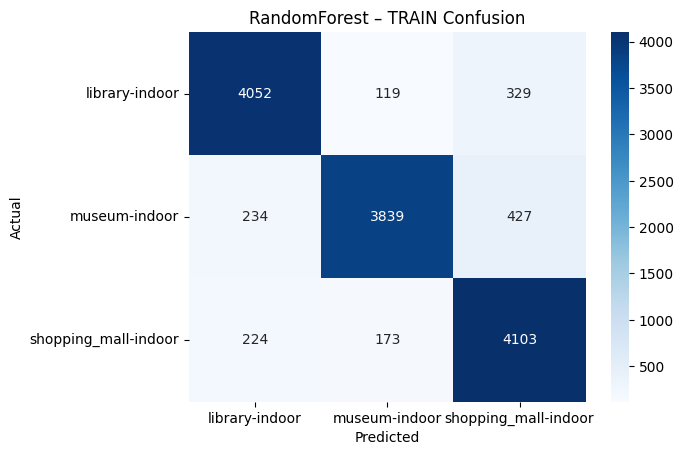


RandomForest — VALIDATION SET
                      precision    recall  f1-score   support

      library-indoor      0.626     0.632     0.629       500
       museum-indoor      0.709     0.618     0.660       500
shopping_mall-indoor      0.664     0.742     0.701       500

            accuracy                          0.664      1500
           macro avg      0.666     0.664     0.663      1500
        weighted avg      0.666     0.664     0.663      1500



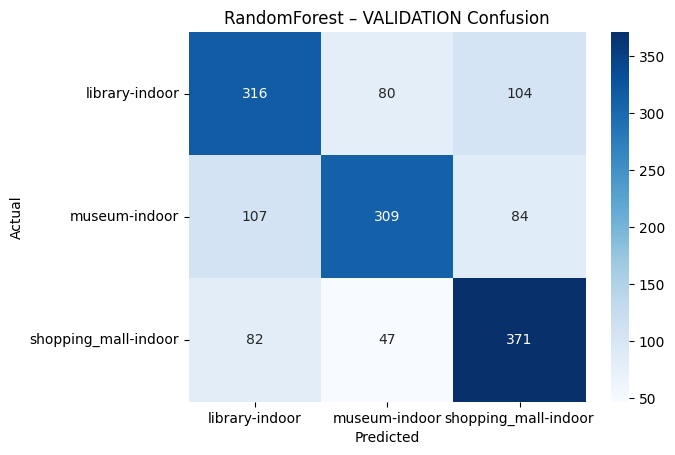


RandomForest — TEST SET
                      precision    recall  f1-score   support

      library-indoor      0.667     0.720     0.692       100
       museum-indoor      0.795     0.700     0.745       100
shopping_mall-indoor      0.702     0.730     0.716       100

            accuracy                          0.717       300
           macro avg      0.721     0.717     0.718       300
        weighted avg      0.721     0.717     0.718       300



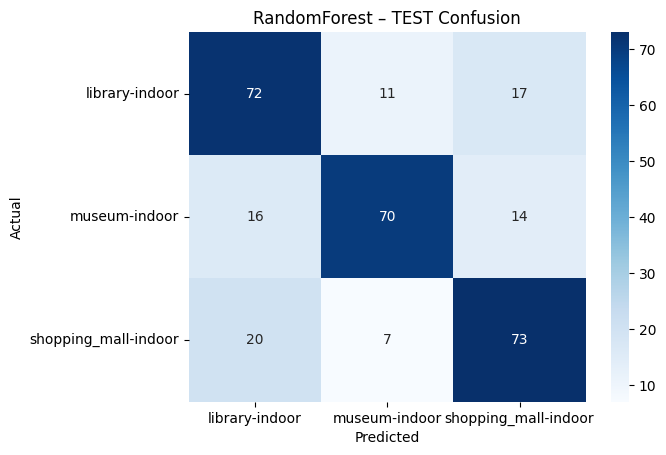

In [ ]:
# save model
joblib.dump(best_rf, "/content/drive/MyDrive/COMP6721/models/best_rf.joblib")

# save cv_results_
pd.DataFrame(search.cv_results_).to_csv("/content/drive/MyDrive/COMP6721/models/best_rf_cv_results.csv", index=False)

# evaluate on TRAIN / VAL / TEST and save metrics dict
metrics = evaluate_model(
    "RandomForest", best_rf,
    X_train_hybrid, y_train_hybrid,
    X_val_hybrid,   y_val_hybrid,
    X_test_hybrid,  y_test_hybrid,
    classes
)
with open("/content/drive/MyDrive/COMP6721/models/best_rf_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

# save predictions
np.save("/content/drive/MyDrive/COMP6721/models/best_rf_test_pred.npy",
        best_rf.predict(X_test_hybrid))


Top 5 CV configs for Random Forest (sorted by mean CV macro-F1):
    param_n_estimators  param_max_depth  param_min_samples_leaf  \
9                  331               14                      11   
4                  329               17                      15   
15                 243               19                      11   
8                  334               18                      12   
2                  303               20                      13   

    param_max_samples  mean_train_score  mean_test_score  std_test_score  
9            0.762625          0.898066         0.702535        0.002864  
4            0.858111          0.877047         0.702221        0.004309  
15           0.791925          0.904768         0.702144        0.004003  
8            0.661613          0.877963         0.701992        0.000773  
2            0.866544          0.896623         0.701937        0.003654  


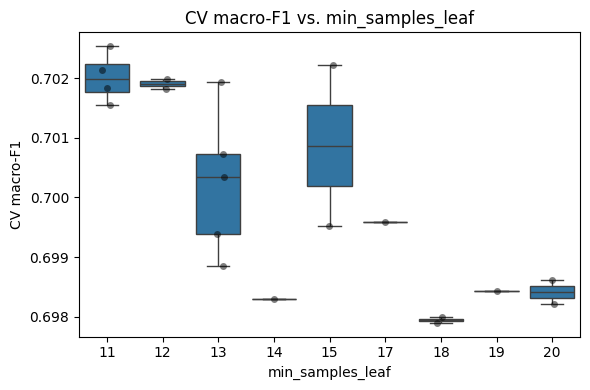

In [ ]:
# DataFrame from RandomizedSearchCV results
cv_rf = pd.DataFrame(search.cv_results_).sort_values(
            "mean_test_score", ascending=False)

# inspect the first few columns
print("\nTop 5 CV configs for Random Forest (sorted by mean CV macro-F1):")
print(cv_rf[[
        "param_n_estimators",
        "param_max_depth",
        "param_min_samples_leaf",
        "param_max_samples",
        "mean_train_score",
        "mean_test_score",
        "std_test_score"
    ]].head())


# Scatter / box plot
plt.figure(figsize=(6,4))
sns.boxplot(
    data=cv_rf,
    x="param_min_samples_leaf",
    y="mean_test_score"
)
sns.stripplot(
    data=cv_rf,
    x="param_min_samples_leaf",
    y="mean_test_score",
    color="k", alpha=0.5
)
plt.title("CV macro-F1 vs. min_samples_leaf")
plt.xlabel("min_samples_leaf"); plt.ylabel("CV macro-F1")
plt.tight_layout()
plt.show()

## Linear SVM



In [ ]:
# Define pipeline: Standardize features then LinearSVC
pipe_svm_linear = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', LinearSVC(max_iter=10000, dual=False, random_state=42))
])
# Hyperparameter grid for C
param_grid = {'clf__C': [0.1, 1, 3, 10]}
grid_svm_linear = GridSearchCV(
    pipe_svm_linear,
    param_grid, cv=3,
    scoring='f1_macro',
    return_train_score=True,
    n_jobs=-1,
    refit=True
)
grid_svm_linear.fit(X_train_hybrid, y_train_hybrid)
print("Linear-SVM best C:", grid_svm_linear.best_params_,
      "CV F1:", grid_svm_linear.best_score_)
best_svm = grid_svm_linear.best_estimator_  # Pipeline with best parameters

Linear-SVM best C: {'clf__C': 0.1} CV F1: 0.6623532435844298



Linear-SVM — TRAIN SET
                      precision    recall  f1-score   support

      library-indoor      0.859     0.860     0.859      4500
       museum-indoor      0.878     0.850     0.864      4500
shopping_mall-indoor      0.867     0.893     0.880      4500

            accuracy                          0.868     13500
           macro avg      0.868     0.868     0.868     13500
        weighted avg      0.868     0.868     0.868     13500



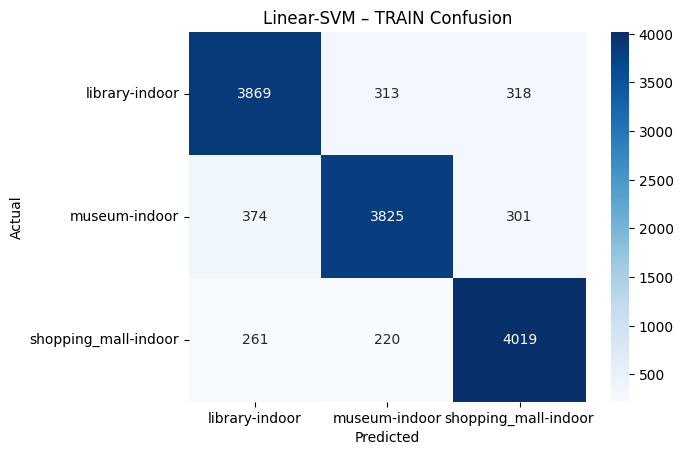


Linear-SVM — VALIDATION SET
                      precision    recall  f1-score   support

      library-indoor      0.643     0.660     0.652       500
       museum-indoor      0.681     0.648     0.664       500
shopping_mall-indoor      0.703     0.718     0.710       500

            accuracy                          0.675      1500
           macro avg      0.675     0.675     0.675      1500
        weighted avg      0.675     0.675     0.675      1500



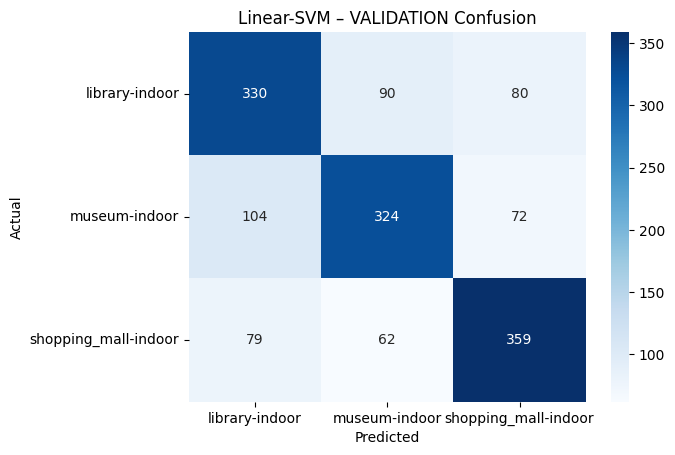


Linear-SVM — TEST SET
                      precision    recall  f1-score   support

      library-indoor      0.660     0.640     0.650       100
       museum-indoor      0.688     0.660     0.673       100
shopping_mall-indoor      0.636     0.680     0.657       100

            accuracy                          0.660       300
           macro avg      0.661     0.660     0.660       300
        weighted avg      0.661     0.660     0.660       300



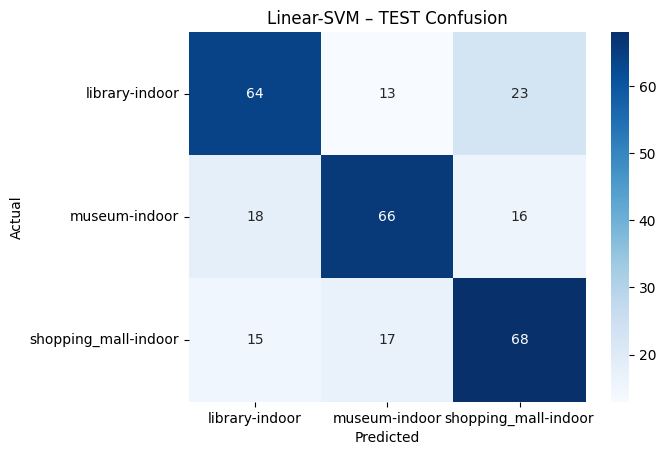

In [ ]:
# save the best pipeline
joblib.dump(
    best_svm,
    "/content/drive/MyDrive/COMP6721/models/best_svm_linear.joblib"
)

# save full CV results
cv_lin = pd.DataFrame(grid_svm_linear.cv_results_)
cv_lin.to_csv(
    "/content/drive/MyDrive/COMP6721/models/best_svm_linear_cv_results.csv",
    index=False
)

# evaluate on TRAIN / VAL / TEST and save metrics dict
metrics_lin = evaluate_model(
    "Linear-SVM", best_svm,
    X_train_hybrid, y_train_hybrid,
    X_val_hybrid,   y_val_hybrid,
    X_test_hybrid,  y_test_hybrid,
    classes
)
with open("/content/drive/MyDrive/COMP6721/models/best_svm_linear_metrics.json", "w") as f:
    json.dump(metrics_lin, f, indent=2)

# 1-d  save test-set predictions
np.save(
    "/content/drive/MyDrive/COMP6721/models/best_svm_linear_test_pred.npy",
    best_svm.predict(X_test_hybrid)
)



Top CV configs for Linear-SVM (macro-F1):
   param_clf__C  mean_train_score  mean_test_score  std_test_score
0           0.1          0.931930         0.662353        0.006246
1           1.0          0.959599         0.637473        0.008467
2           3.0          0.971264         0.627440        0.006528
3          10.0          0.979979         0.618965        0.005993


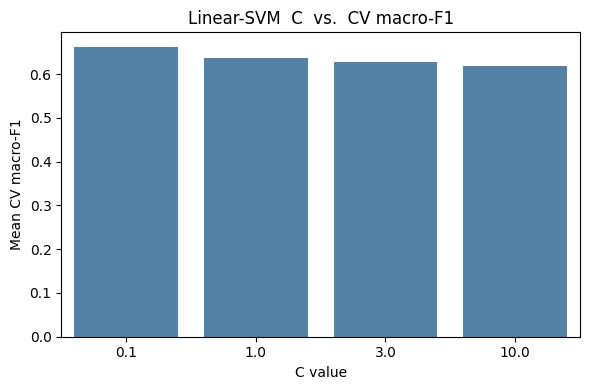

In [ ]:
print("\nTop CV configs for Linear-SVM (macro-F1):")
print(cv_lin.sort_values("mean_test_score", ascending=False)[[
        "param_clf__C",
        "mean_train_score",
        "mean_test_score",
        "std_test_score"
    ]].head())

# -- simple bar plot of C vs. mean CV macro-F1 --
plt.figure(figsize=(6,4))
sns.barplot(
    x=cv_lin["param_clf__C"].astype(float),
    y=cv_lin["mean_test_score"],
    color="steelblue"
)
plt.title("Linear-SVM  C  vs.  CV macro-F1")
plt.xlabel("C value"); plt.ylabel("Mean CV macro-F1")
plt.tight_layout()
plt.show()

## Radial Basis Function SVM

### SVM (RBF) – Focused Grid Search  

| Hyper-parameter | Candidate values | Rationale |
|-----------------|------------------|-----------|
| $C$             | $\{1,\;2,\;2.5\}$ | explores low → moderate regularisation |
| $\gamma$        | $\{1\times10^{-4},\;3\times10^{-4},\;1\times10^{-3}\}$ | spans one decade of kernel curvature |

**Grid size:** $3 \times 3 = 9$ combos  
**CV:** 3-fold stratified (macro-F1)  

**Outputs**  
* best model → `best_rbf_svm.joblib`  
* full `cv_results_` → CSV for heat-map diagnostics




In [ ]:
# Build SVM pipeline  (scaler + RBF kernel)
pipe_rbf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='rbf', probability=False, random_state=42))
])
param_grid_rbf = {
    'clf__C': [1, 2, 2.5],     # [2,2.5]
    'clf__gamma': [1e-4, 3e-4, 1e-3]      #again C=3, g=0.0005   0.00038
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_rbf = GridSearchCV(
    pipe_rbf,
    param_grid_rbf,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    return_train_score=True,
    refit=True
)


grid_rbf.fit(X_train_hybrid, y_train_hybrid)
print("Best RBF SVM params:", grid_rbf.best_params_)
print("Best RBF SVM CV macro-F1:", grid_rbf.best_score_)
best_rbf = grid_rbf.best_estimator_

Best RBF SVM params: {'clf__C': 2.5, 'clf__gamma': 0.0003}
Best RBF SVM CV macro-F1: 0.751054058751663



RBF SVM — TRAIN SET
                      precision    recall  f1-score   support

      library-indoor      0.990     0.990     0.990      4500
       museum-indoor      0.998     0.979     0.988      4500
shopping_mall-indoor      0.977     0.995     0.986      4500

            accuracy                          0.988     13500
           macro avg      0.988     0.988     0.988     13500
        weighted avg      0.988     0.988     0.988     13500



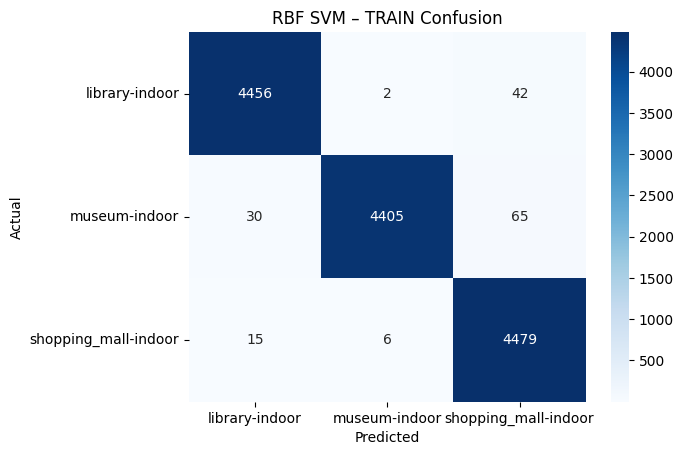


RBF SVM — VALIDATION SET
                      precision    recall  f1-score   support

      library-indoor      0.710     0.736     0.723       500
       museum-indoor      0.749     0.706     0.727       500
shopping_mall-indoor      0.748     0.764     0.756       500

            accuracy                          0.735      1500
           macro avg      0.736     0.735     0.735      1500
        weighted avg      0.736     0.735     0.735      1500



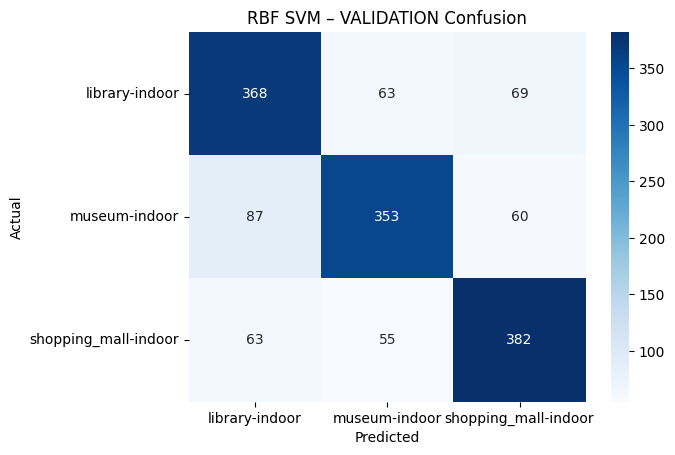


RBF SVM — TEST SET
                      precision    recall  f1-score   support

      library-indoor      0.745     0.760     0.752       100
       museum-indoor      0.778     0.700     0.737       100
shopping_mall-indoor      0.741     0.800     0.769       100

            accuracy                          0.753       300
           macro avg      0.755     0.753     0.753       300
        weighted avg      0.755     0.753     0.753       300



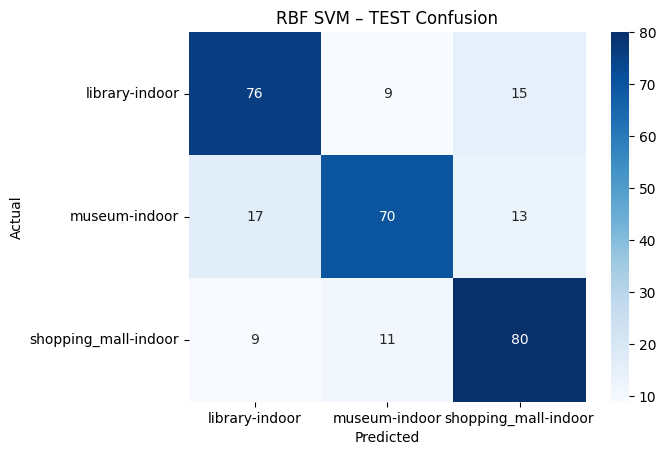

In [ ]:
# save the best pipeline
joblib.dump(
    best_rbf,
    "/content/drive/MyDrive/COMP6721/models/best_rbf_svm.joblib"
)

cv_rbf = pd.DataFrame(grid_rbf.cv_results_)
cv_rbf.to_csv(
    "/content/drive/MyDrive/COMP6721/models/best_rbf_svm_cv_results.csv",
    index=False
)

metrics_rbf = evaluate_model(
    "RBF SVM", best_rbf,
    X_train_hybrid, y_train_hybrid,
    X_val_hybrid,   y_val_hybrid,
    X_test_hybrid,  y_test_hybrid,
    classes
)
with open("/content/drive/MyDrive/COMP6721/models/best_rbf_svm_metrics.json", "w") as f:
    json.dump(metrics_rbf, f, indent=2)

np.save(
    "/content/drive/MyDrive/COMP6721/models/best_rbf_svm_test_pred.npy",
    best_rbf.predict(X_test_hybrid)
)


Top 5 CV configs for RBF SVM (macro-F1):
   param_clf__C  param_clf__gamma  mean_train_score  mean_test_score  \
7           2.5            0.0003          0.989673         0.751054   
4           2.0            0.0003          0.977870         0.749516   
1           1.0            0.0003          0.907775         0.739970   
6           2.5            0.0001          0.859807         0.732021   
3           2.0            0.0001          0.843648         0.731487   

   std_test_score  
7        0.000813  
4        0.003576  
1        0.000649  
6        0.002312  
3        0.003227  


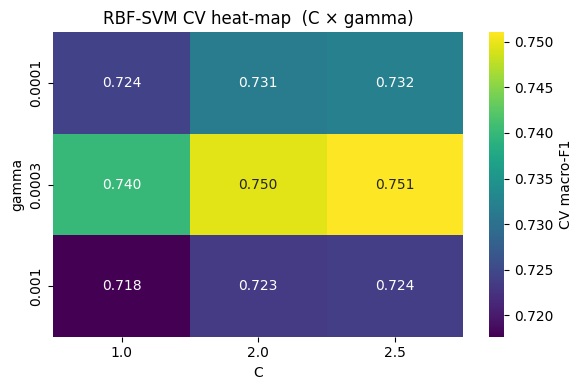

In [ ]:
print("\nTop 5 CV configs for RBF SVM (macro-F1):")
print(cv_rbf.sort_values("mean_test_score", ascending=False)[[
        "param_clf__C",
        "param_clf__gamma",
        "mean_train_score",
        "mean_test_score",
        "std_test_score"
    ]].head())

# heat-map C × gamma
cv_rbf["C"]     = cv_rbf["param_clf__C"].astype(str)
cv_rbf["gamma"] = cv_rbf["param_clf__gamma"].astype(str)

pivot_rbf = cv_rbf.pivot_table(
    index="gamma",
    columns="C",
    values="mean_test_score"
)

plt.figure(figsize=(6,4))
sns.heatmap(pivot_rbf, annot=True, fmt=".3f", cmap="viridis",
            cbar_kws={"label": "CV macro-F1"})
plt.title("RBF-SVM CV heat-map  (C × gamma)")
plt.xlabel("C"); plt.ylabel("gamma")
plt.tight_layout()
plt.show()

## Decision Tree Semi-Supervised Learning

1. Merge Train + Val ⇒ 15 000 samples.  
2. Stratified split 20 % (labelled) / 80 % (unlabelled).  

In [ ]:
# Combine TRAIN + VAL = 15 000 examples
X_pool = np.vstack([X_train_hybrid, X_val_hybrid])
y_pool = np.hstack([y_train_hybrid, y_val_hybrid])
print("Pool size  (labelled+unlabelled):", X_pool.shape)

# Split: 20 % labelled  |  80 % unlabelled
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.80, random_state=42)
lbl_idx, unl_idx = next(sss.split(X_pool, y_pool))
X_lbl,  y_lbl  = X_pool[lbl_idx],  y_pool[lbl_idx]
X_unl,  y_unl  = X_pool[unl_idx],  y_pool[unl_idx]
print(f"Labeled = {len(y_lbl)}  |  Unlabeled = {len(y_unl)}")

Pool size  (labelled+unlabelled): (15000, 2584)
Labeled = 3000  |  Unlabeled = 12000


**Self-training loop**

In [ ]:
def self_train_decision_tree(
        X_lbl, y_lbl, X_unl,
        *, max_iter=15, conf_th=0.90, min_add=150,
        **tree_kw):
    """
    Self-training loop for multi-class DecisionTree.
    Returns (final_tree, history_df).
    """
    history = []
    for it in range(1, max_iter+1):
        clf = DecisionTreeClassifier(**tree_kw, random_state=42)
        clf.fit(X_lbl, y_lbl)

        # predict proba on unlabeled set
        proba = clf.predict_proba(X_unl)           # shape (n_unl, n_classes)
        conf  = proba.max(axis=1)                  # highest class prob per sample
        pseudo= proba.argmax(axis=1)               # predicted label

        sel_mask = conf >= conf_th
        n_new    = sel_mask.sum()

        f1_tr = f1_score(y_lbl, clf.predict(X_lbl), average="macro")
        history.append({"iter":it,
                        "n_labeled":len(y_lbl),
                        "n_pseudo":n_new,
                        "f1_train":f1_tr,
                        "confidence_threshold":conf_th})
        print(f"Iter {it}: added {n_new:4d} pseudo-labels  |  new labelled total {len(y_lbl)+n_new}")
        print(f"Confidence threshold: {conf_th:.2f}")
        if n_new < min_add:
            print("Stopping – not enough confident predictions.")
            break

        # extend labeled pool
        X_lbl  = np.vstack([X_lbl,  X_unl[sel_mask]])
        y_lbl  = np.hstack([y_lbl,  pseudo[sel_mask]])
        # shrink unlabeled pool
        X_unl  = X_unl[~sel_mask]
        conf_th = max(conf_th - 0.02, 0.85)


    return clf, pd.DataFrame(history)

tree_final, hist = self_train_decision_tree(
        X_lbl, y_lbl, X_unl,
        max_depth=20,
        min_samples_leaf=20,
        max_iter=10,
        conf_th=0.95, #95 max_iter 10
        min_add=100)

print("\nSelf-training history\n", hist)

Iter 1: added 3863 pseudo-labels  |  new labelled total 6863
Confidence threshold: 0.950
Iter 2: added  898 pseudo-labels  |  new labelled total 7761
Confidence threshold: 0.930
Iter 3: added  190 pseudo-labels  |  new labelled total 7951
Confidence threshold: 0.910
Iter 4: added  332 pseudo-labels  |  new labelled total 8283
Confidence threshold: 0.890
Iter 5: added  532 pseudo-labels  |  new labelled total 8815
Confidence threshold: 0.870
Iter 6: added 1145 pseudo-labels  |  new labelled total 9960
Confidence threshold: 0.850
Iter 7: added  221 pseudo-labels  |  new labelled total 10181
Confidence threshold: 0.850
Iter 8: added  432 pseudo-labels  |  new labelled total 10613
Confidence threshold: 0.850
Iter 9: added 1339 pseudo-labels  |  new labelled total 11952
Confidence threshold: 0.850
Iter 10: added  515 pseudo-labels  |  new labelled total 12467
Confidence threshold: 0.850

Self-training history
    iter  n_labeled  n_pseudo  f1_train  confidence_threshold
0     1       3000  

**Evaluation**


Semi-sup DecisionTree — TRAIN SET
                      precision    recall  f1-score   support

      library-indoor      0.535     0.674     0.597      5000
       museum-indoor      0.692     0.538     0.605      5000
shopping_mall-indoor      0.670     0.645     0.657      5000

            accuracy                          0.619     15000
           macro avg      0.632     0.619     0.620     15000
        weighted avg      0.632     0.619     0.620     15000



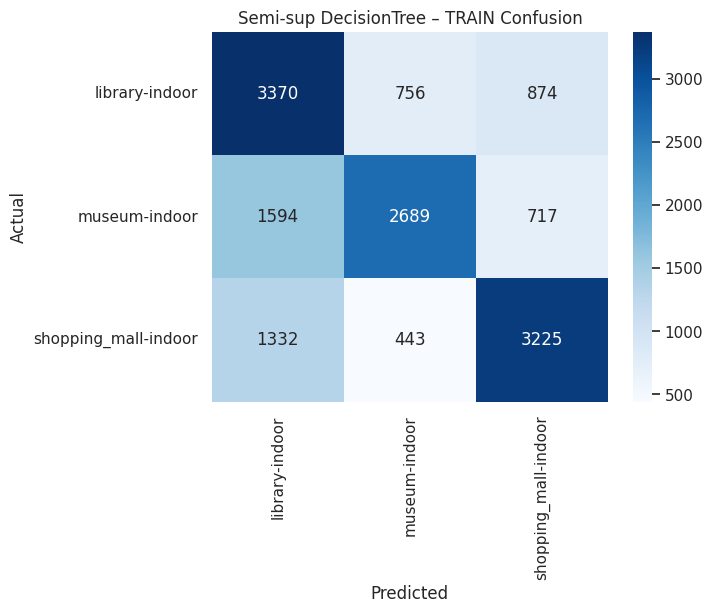


Semi-sup DecisionTree — VALIDATION SET
                      precision    recall  f1-score   support

      library-indoor      0.502     0.644     0.564       500
       museum-indoor      0.665     0.504     0.573       500
shopping_mall-indoor      0.662     0.634     0.648       500

            accuracy                          0.594      1500
           macro avg      0.609     0.594     0.595      1500
        weighted avg      0.609     0.594     0.595      1500



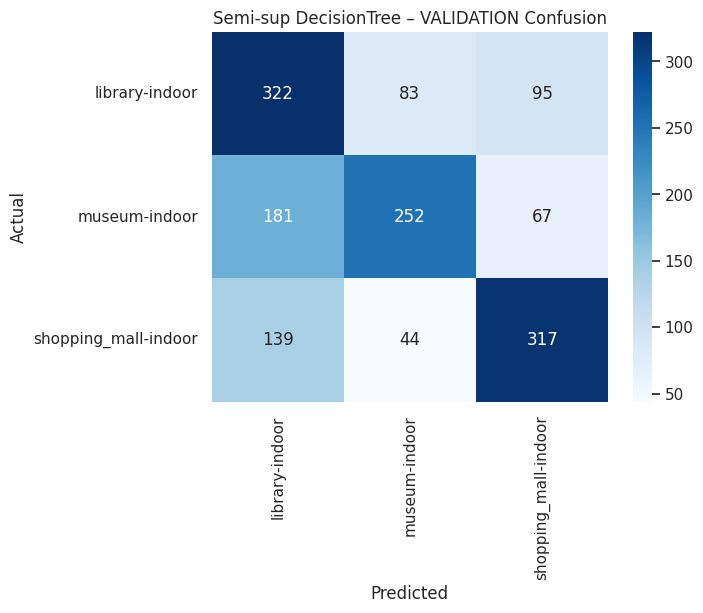


Semi-sup DecisionTree — TEST SET
                      precision    recall  f1-score   support

      library-indoor      0.511     0.690     0.587       100
       museum-indoor      0.750     0.510     0.607       100
shopping_mall-indoor      0.649     0.630     0.640       100

            accuracy                          0.610       300
           macro avg      0.637     0.610     0.611       300
        weighted avg      0.637     0.610     0.611       300



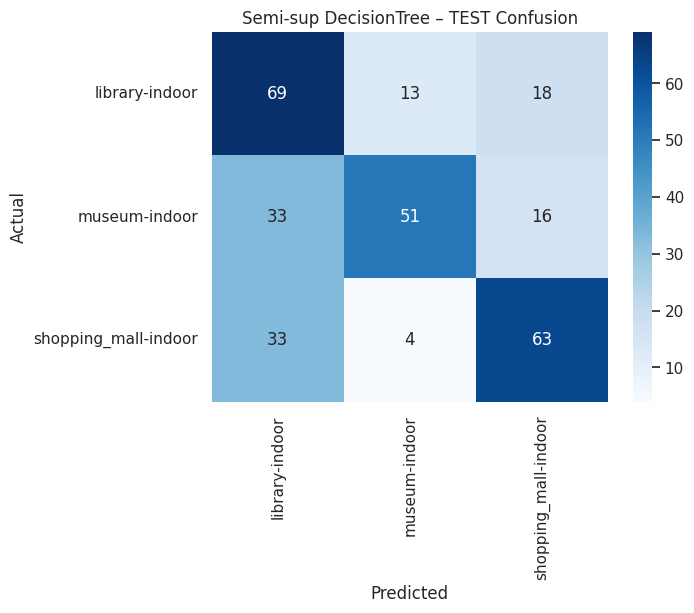

In [ ]:
metrics_semi = evaluate_model(
    "Semi-sup DecisionTree", tree_final,
    X_pool,  y_pool,
    X_val_hybrid, y_val_hybrid,
    X_test_hybrid, y_test_hybrid,
    classes
)

In [ ]:
# save
joblib.dump(tree_final, "/content/drive/MyDrive/COMP6721/models/semisup_tree.joblib")
hist.to_csv("/content/drive/MyDrive/COMP6721/models/semisup_tree_history.csv",index=False)

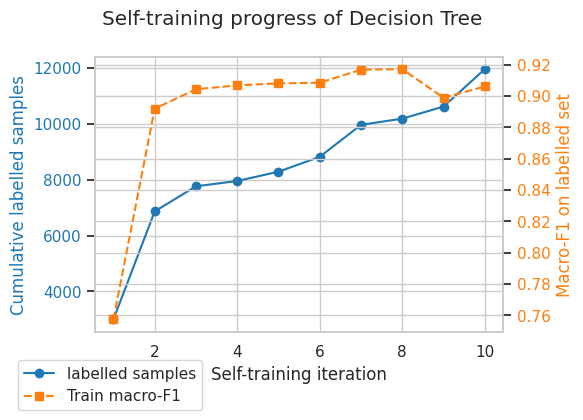

In [ ]:
sns.set_theme(style="whitegrid")

fig, ax1 = plt.subplots(figsize=(6,4))

# growth of the labelled subset
ax1.plot(hist["iter"], hist["n_labeled"],
         marker="o", label="labelled samples", color="tab:blue")
ax1.set_xlabel("Self-training iteration")
ax1.set_ylabel("Cumulative labelled samples", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# training macro-F1 on a second y-axis
ax2 = ax1.twinx()
ax2.plot(hist["iter"], hist["f1_train"],
         marker="s", linestyle="--", label="Train macro-F1",
         color="tab:orange")
ax2.set_ylabel("Macro-F1 on labelled set", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

# cosmetics
fig.suptitle("Self-training progress of Decision Tree")
fig.tight_layout()
fig.legend(loc="lower left", bbox_to_anchor=(0.03, -0.04))
plt.show()

## Semi Supervised Decision Tree By Nitheesh


In [ ]:
SAVE_PATH = "/content/drive/MyDrive/COMP6721/hog_bovw_hybrid_semisup.npz"
data_bovw_hybrid = np.load(SAVE_PATH, allow_pickle=True)
X_train_hybrid = data_bovw_hybrid['X_train']   # shape (n_train_sub, D_bovw)
y_train_hybrid = data_bovw_hybrid['y_train']
X_val_hybrid   = data_bovw_hybrid['X_val']     # shape (n_val, D_bovw)
y_val_hybrid   = data_bovw_hybrid['y_val']
X_test_hybrid  = data_bovw_hybrid['X_test']    # shape (n_test, D_bovw)
y_test_hybrid  = data_bovw_hybrid['y_test']
classes      = data_bovw_hybrid['classes']

print("Hog with BoVW+LBP shapes:",
      X_train_hybrid.shape, X_val_hybrid.shape, X_test_hybrid.shape)

Hog with BoVW+LBP shapes: (13500, 2584) (1500, 2584) (300, 2584)


In [ ]:
rng = np.random.RandomState(3)
y_train = y_train_hybrid.copy()
mask_unlabeled = np.zeros_like(y_train, dtype=bool)

# Mask 80% of each class
for class_label in np.unique(y_train):
    class_indices = np.where(y_train == class_label)[0]
    n_unlabeled = int(0.8 * len(class_indices))
    unlabeled_indices = rng.choice(class_indices, size=n_unlabeled, replace=False)
    mask_unlabeled[unlabeled_indices] = True

y_train[mask_unlabeled] = -1

# separate labeled and unlabeled index
labelled_idx = y_train != -1
unlabelled_idx = y_train == -1

# Initial Labeled and unlabelled data
X_labelled,  y_labelled  = X_train_hybrid[labelled_idx],  y_train_hybrid[labelled_idx]
X_unlabelled,  y_unlabelled  = X_train_hybrid[unlabelled_idx],  y_train_hybrid[unlabelled_idx]
print(f"Labeled = {len(y_labelled)}  |  Unlabeled = {len(y_unlabelled)}")

Labeled = 2700  |  Unlabeled = 10800


In [ ]:
def self_train_decision_tree(
        X_labelled, y_labelled, X_unlabelled,
        max_iter=10, conf_th=0.90):
    """
    Self-training loop for multi-class DecisionTree.
    Returns (final_tree, history_df).
    """
    history = []
    for it in range(1, max_iter+1):
        clf = DecisionTreeClassifier(criterion='entropy',
                                 min_samples_leaf = 10,
                                 class_weight='balanced',
                                 random_state=3)
        clf.fit(X_labelled, y_labelled)

        if len(X_unlabelled) == 0:
            print(f"No unlabeled data left in iteration: {it}")
            break

        # predict proba on unlabeled set
        probs = clf.predict_proba(X_unlabelled)          # shape (n_unl, n_classes)
        max_probs = np.max(probs, axis = 1)             # highest class prob per sample
        confident_mask = max_probs >= conf_th
        confident_X = X_unlabelled[confident_mask]       # unlabelled observations with high confidence
        pseudo_y = np.argmax(probs[confident_mask], axis = 1) # predicted label
        n_new = np.sum(confident_mask)

        if not np.any(confident_mask):
            print(f"No confident predictions found in iteration: {it}")
            break
        f1_val = f1_score(y_val_hybrid, clf.predict(X_val_hybrid), average="macro")
        history.append({"iter":it,
                        "n_labeled":len(y_labelled),
                        "n_pseudo":n_new,
                        "f1_val": f1_val
                        })
        print(f"Iter {it}: added {n_new:4d} pseudo-labels  |  new labelled total {len(y_labelled)+n_new}")

        # extend labeled pool
        X_labelled  = np.vstack([X_labelled,  confident_X])
        y_labelled  = np.concatenate([y_labelled,  pseudo_y])
        # shrink unlabeled pool
        X_unlabelled  = X_unlabelled[~confident_mask]

    return clf, pd.DataFrame(history)

tree_final, hist = self_train_decision_tree(
        X_labelled, y_labelled, X_unlabelled,
        max_iter=15, conf_th=0.90)

print("\nSelf-training history\n", hist)

Iter 1: added 6343 pseudo-labels  |  new labelled total 9043
Iter 2: added 2012 pseudo-labels  |  new labelled total 11055
Iter 3: added  608 pseudo-labels  |  new labelled total 11663
Iter 4: added  248 pseudo-labels  |  new labelled total 11911
Iter 5: added   92 pseudo-labels  |  new labelled total 12003
Iter 6: added   83 pseudo-labels  |  new labelled total 12086
Iter 7: added  137 pseudo-labels  |  new labelled total 12223
Iter 8: added   29 pseudo-labels  |  new labelled total 12252
Iter 9: added   32 pseudo-labels  |  new labelled total 12284
Iter 10: added    2 pseudo-labels  |  new labelled total 12286
No confident predictions found in iteration: 11

Self-training history
    iter  n_labeled  n_pseudo    f1_val
0     1       2700      6343  0.528008
1     2       9043      2012  0.554032
2     3      11055       608  0.551277
3     4      11663       248  0.554718
4     5      11911        92  0.552719
5     6      12003        83  0.557937
6     7      12086       137  0.550

In [ ]:
def eval_split(name, clf, X, y):
    y_pred = clf.predict(X)
    acc = accuracy_score(y, y_pred)
    f1  = f1_score(y, y_pred, average="macro")
    print(f"{name:<10}  acc={acc:.3f}  f1={f1:.3f}")
    return acc, f1

print("\n=== Final DecisionTree performance ===")
eval_split("TRAIN-ALL", tree_final, X_train_hybrid, y_train_hybrid)          #X_pool,  y_pool)
eval_split("VAL (old)", tree_final, X_val_hybrid, y_val_hybrid)
eval_split("TEST",      tree_final, X_test_hybrid, y_test_hybrid)

print("\nTest classification report:")
print(classification_report(y_train_hybrid,
                            tree_final.predict(X_train_hybrid),
                            target_names=classes, digits=3))

print("\nValidation classification report:")
print(classification_report(y_val_hybrid,
                            tree_final.predict(X_val_hybrid),
                            target_names=classes, digits=3))

print("\nTest classification report:")
print(classification_report(y_test_hybrid,
                            tree_final.predict(X_test_hybrid),
                            target_names=classes, digits=3))


=== Final DecisionTree performance ===
TRAIN-ALL   acc=0.631  f1=0.630
VAL (old)   acc=0.555  f1=0.555
TEST        acc=0.600  f1=0.599

Test classification report:
                      precision    recall  f1-score   support

      library-indoor      0.601     0.576     0.588      4500
       museum-indoor      0.658     0.625     0.641      4500
shopping_mall-indoor      0.633     0.691     0.661      4500

            accuracy                          0.631     13500
           macro avg      0.631     0.631     0.630     13500
        weighted avg      0.631     0.631     0.630     13500


Validation classification report:
                      precision    recall  f1-score   support

      library-indoor      0.517     0.522     0.519       500
       museum-indoor      0.578     0.516     0.545       500
shopping_mall-indoor      0.572     0.628     0.599       500

            accuracy                          0.555      1500
           macro avg      0.556     0.555     0.555

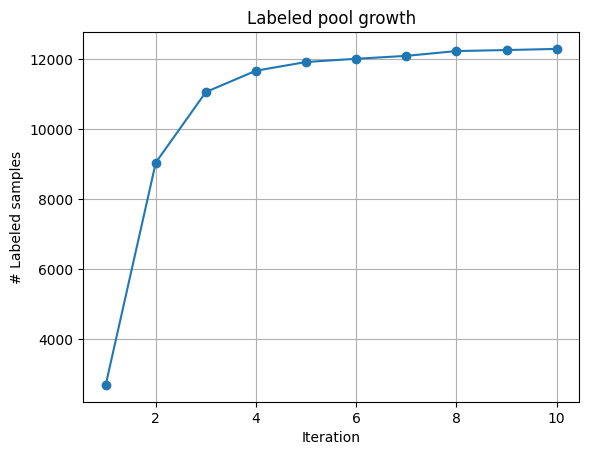

In [ ]:
plt.plot(hist["iter"], hist["n_labeled"], marker='o')
plt.title("Labeled pool growth")
plt.xlabel("Iteration"); plt.ylabel("# Labeled samples")
plt.grid(True); plt.show()